## Component objective

The goal of this component is to form groupings from the current customers base based on hidden characteristics, if there is any. In addtion, the following analysis will provide detailed explainations on the grouping results as well as the methodologies being employed based on customers' purchasing frequency, monetary value spent, age and gender, etc.

Methodology to be examined:
- RFM (frequency, recency, monetary) segmentation  
- Unsupervised learning; principle component analysis, k-prototype clustering

## Table of contents

1. RFM analysis
2. Customer segmentation based on unsupervised learning
    - principle component analysis
    - k-prototype clustering

## 1. RFM analysis
- Please note that in order to perform the RFM analysis, I would need to calculate recency for each customer. The recency represents the number of hours passed since last interaction with the offer. 
- It's noticed that the maximum value of the "time" column is 714 which means the number of hours has passed, for that person to initiate certain actions is 714 hours. 
- Since there is no customers that made any actions after the 714 hour mark, I will make an assumption that the starting hour for the RFM analysis begin is at the 715th hour. This represents after 715 hours, since the begining of the test, we begin our RFM analysis.
- For real life uses, we should substitute this 715 hour with another suitable time metric that marks the begining of the RFM analysis. For example, 1000 or 2000 which represent the number of hours that have passed since the begining of the testing period.
- Please note that whenever the time column has a value, its corresponding event could be all event types (offer received, offer viewed, transaction, offer completed). This means that the yet to be created recency column represents a customer action instead of just the purchasing action. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn import preprocessing
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [2]:
path = 'C:/Users/607991/Desktop/Starbucks Capstone/Data/Processed'
profile = pd.read_csv(path+'/profile_processed.csv')
transcript = pd.read_csv(path+'/transcript_processed.csv')

In [3]:
# bring in recency information for each customer

temp = transcript.groupby('person').max().time
profile.set_index('id', inplace=True)
profile = profile.join(temp)

# create recency for each customer

profile['recency'] = 715 - profile.time

# getting the columns that are only relevant to the RFM analysis

rfm = profile[['recency','offer_completed','amount_spent']].copy()

# change column names for convenient 

rfm.columns = ['recency', 'frequency', 'monetary']

# calculate quantile of rfm values
# customers with the lowest recency, highest frequency and monetary amounts considered as top customers

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

# rfm results calculation

rfm['rfm_score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,rfm_score
id,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,19,2.0,20.40,1,3,4,134
0610b486422d4921ae7d2bf64640c50b,187,1.0,77.01,4,4,2,442
38fe809add3b4fcf9315a9694bb96ff5,19,0.0,14.30,1,4,4,144
78afa995795e4d85b5d9ceeca43f5fef,133,3.0,159.27,4,2,1,421
a03223e636434f42ac4c3df47e8bac43,91,0.0,4.65,3,4,4,344


In [4]:
# interpret segmentation results

print('Top 30 groupings made up 50% of the totol number of groups resulted from RFM analylsis. So we will only display top 30 groupings here.')
print('We observe that among the top 30 groupings that have amount of people, grouping 444, 344, 244, 111, 144 are the top 5s.')

rfm.groupby('rfm_score').size().sort_values(ascending=False)[:30]

Top 30 groupings made up 50% of the totol number of groups resulted from RFM analylsis. So we will only display top 30 groupings here.
We observe that among the top 30 groupings that have amount of people, grouping 444, 344, 244, 111, 144 are the top 5s.


rfm_score
444    1537
344    1020
244     824
111     772
144     725
211     695
143     674
243     612
443     563
311     544
343     521
121     419
133     377
221     363
122     358
222     354
322     352
233     329
432     325
232     317
212     308
132     290
333     287
312     285
112     284
332     268
422     264
321     262
433     259
411     216
dtype: int64

For each customer, the lower their recency, frequency and monetary quantiles, the better. In other words, grouping 111 is better than 222, and group 222 is better than 224.

Top 5 grouping representation:
- 444, customers with high recency, low frequency and low monetary value
- 344, customers with relatively high recency, low frequency and low monetary value
- 244, customers with medium recency, low frequency and low monetary value
- 111, customers with low recency, high frequency and high monetary value
- 144, customers with low recency, low frequency and low monetary value

Note that customer grouping 111, is the most ideal group. But it ranks number 4 in terms of grouping size.

Further grouping interpretation:
- 444, customers who had their last offer interaction (could be all event types) long time ago, and have less number of offers completed with low total purchase amount druing the test period.
    - Customers who don't interact with the offers they received, and they tend to complete less offers that worth low total purchase amount. 
- 344, customers who had their last offer action (could be all event types) some time ago, and have less number of offers completed with low total purchase amount druing the test period.
    - Customers who rarely interact with the offers they received, and they tend to complete less offers that worth low total purchase amount. 
- 244, customers who had their last offer action (could be all event types) recently, and have less number of offers completed with low total purchase amount druing the test period.
    - Customers who sometimes interact with the offers they received, but they tend to complete less offers that worth low total purchase amount. 
- 111, customers who just had their last offer action (could be all event types), and have more number of offers completed with high total purchase amount druing the test period.
    - Customers who interact with the offers they receive often, and they tend to complete many offers that worth high total purchase amount.
- 144, customers who just had their last offer action (could be all event types), but have less number of offers completed with low total purchase amount druing the test period.
    - Customers who interact with the offers they receive often, but they tend to complete less offers that worth low total worth of purchase amount.

In [5]:
# summing the score

rfm['rfm_score_sum'] = rfm.r_quartile.astype('float') + rfm.f_quartile.astype('float') + rfm.m_quartile.astype('float')
rfm.groupby('rfm_score_sum').agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).round(1)

,recency,frequency,monetary
rfm_score_sum,,,
3.0,12.6,4.5,275.2
4.0,28.3,4.0,232.1
5.0,46.4,3.6,195.8
6.0,59.9,3.1,158.3
7.0,62.3,2.4,116.8
8.0,62.5,1.7,78.6
9.0,64.0,1.0,48.4
10.0,84.3,0.7,33.5
11.0,110.8,0.4,20.7


Introduce new grouping methods:
- Previously, we went through the grouping representaions and explained that the lower the number on each spot of the 3-digit group number, the better. This grouping method is achieved by concatnating the recency, frequency and monetary quantiles together. 
- Because of the nature of this method, we ended only showing top 30 grouping representations that has larger grouping size. In total, we have 60 of such resulted groupings. This is hard to interpret, so to reduce the high cardinality, we can simply sum up all three quantiles and get a single result that ranges from 3-12. This way, we obtain 10 unique grouping results, rather than 60. 

New grouping results:
- Customers with new grouping score of 3, and 4 have the highest average monetary value, these customers should be the most ideal to the business.
- Customers with new grouping score of 5-7 should be interpreted together because their average monetary value are all above \\$100 dollars.
- Customers with new grouping score of 8-11 should be interpreted together because their average monetary value are all less \\$100 but still maintains 2-digit average spent. 
- Customer with new grouping score being 12 should be interpreted alone because their average monetary value is only \\$8.5 dollars.

In [6]:
# according to the findings, assign each customer to a group

def rfm_segment(data):
    if data['rfm_score_sum'] < 5:
        return 'ideal'
    if data['rfm_score_sum'] < 8:
        return 'valuable'
    if data['rfm_score_sum'] < 12:
        return 'need_to_reach_out'
    else:
        return 'not_spending_enough'
    
rfm['rfm_segments'] = rfm.apply(rfm_segment, axis=1)

# appending the rfm segmentation results back to the profile dataset

temp = rfm.drop(['recency','frequency','monetary'], axis=1)
profile = profile.join(temp)
profile.groupby('rfm_segments').size().sort_values(ascending=False)

rfm_segments
need_to_reach_out      7778
valuable               5515
ideal                  2170
not_spending_enough    1537
dtype: int64

- It's observed that based on RFM segmentation, the "ideal" customer group counted as 12.7% of the population, ranked as the third largest group among all customers.
- The "valuable" customer group counted as 32.4% of the population, and ranked the second largest group of the all segmentations.

### 1. RFM analysis conclusion

Summary:
- Using RFM analysis, we defined that customers with the lowest recency, highest frequency and monetary values are considered as top customers. Furthermore, the way we encode customers' monetary, recency, and frequency values are as follow:
    - 111 represents customers with lowest recency, highest frequency and monetary values.
    - 444 represents customers with highest recency, lowest frequency and monetary values.
- Based the the above representation, we obtained 60 customer groups. This grouping impose certain challengs during inpterpretations. Thus we introduced another way of segmentation methods by summing up customers recency, frequency and monetary quantiles into one number. For example, our top customers with previous segmentation label "111", is now a 3, and customers with previous segmentation label "444" is a 12 now.

Conclusion:
- Based on the new segmentation method, the "ideal" customer group made up 12.7% of the entire population, while the "valuable" customer group counts 32.4% of the population. 
- Among these two preferred groups, customers are expected to have higher total purchase amount, high number of completed offers, and their last interaction with the offers they receive is very close to the time that this anlaysis is performed. 

## 2. K-prototype clustering

K-prototype is designed when the dataset has categorical features. But first, we would need to reduce the number of demensions that numerical features represent. This can be done through Principle Component Analysis.

In [7]:
# standardizing all the numerical variables, but first convert the quartile variables to object 
# then droup the original time variable

profile.r_quartile = profile.r_quartile.astype('object')
profile.f_quartile = profile.f_quartile.astype('object')
profile.m_quartile = profile.m_quartile.astype('object')
profile.drop('became_member_on', axis=1, inplace=True)
profile['income'].fillna(profile.income.median(), inplace=True)

num_features=profile.select_dtypes(exclude='object').columns
profile[num_features]=preprocessing.MinMaxScaler().fit_transform(profile[num_features])
profile.head()

,age,gender,income,age_group,became_member_year,became_member_month,became_member_day,became_member_weekday,offer_received,offer_viewed,offer_completed,offer_received_viewed_completed,offer_not_received_completed,offer_not_viewed_completed,amount_spent,reward_received,no_purchase,with_purchase,time,recency,r_quartile,f_quartile,m_quartile,rfm_score,rfm_score_sum,rfm_segments
id,,,,,,,,,,,,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,1.00,NaN,0.377778,NaN,0.8,0.090909,0.366667,1.000000,0.833333,0.833333,0.333333,0.333333,0.0,0.00,0.012681,0.090909,made_purchase,purchased_viewed,0.958904,0.041096,1,3,4,134,0.555556,need_to_reach_out
0610b486422d4921ae7d2bf64640c50b,0.37,F,0.911111,50-59,0.8,0.545455,0.466667,0.833333,0.333333,0.000000,0.166667,0.000000,0.0,0.25,0.047871,0.090909,made_purchase,purchased_received_no_view,0.575342,0.424658,4,4,2,442,0.777778,need_to_reach_out
38fe809add3b4fcf9315a9694bb96ff5,1.00,NaN,0.377778,NaN,1.0,0.545455,0.366667,0.500000,0.333333,0.333333,0.000000,0.000000,0.0,0.00,0.008889,0.000000,made_purchase,purchased_viewed,0.958904,0.041096,1,4,4,144,0.666667,need_to_reach_out
78afa995795e4d85b5d9ceeca43f5fef,0.57,F,0.777778,70-79,0.8,0.363636,0.266667,0.166667,0.666667,0.666667,0.500000,0.500000,0.0,0.00,0.099006,0.363636,made_purchase,purchased_viewed,0.698630,0.301370,4,2,1,421,0.444444,valuable
a03223e636434f42ac4c3df47e8bac43,1.00,NaN,0.377778,NaN,0.8,0.636364,0.100000,0.666667,0.833333,0.500000,0.000000,0.000000,0.0,0.00,0.002891,0.000000,made_purchase,purchased_viewed,0.794521,0.205479,3,4,4,344,0.888889,need_to_reach_out


In [8]:
# to understand if the dataset can be clustered, we used the Hopkins statistic, which tests the spatial randomness 
# of the data and indicates the cluster tendency or how well the data can be clustered.

# if the value is around 0.5 or below, the data is uniformly distributed and hence it is unlikely to have significant results
# If the value is above 0.5, it has a high tendency to cluster and therefore likely to have statistically significant results

def hopkins(data):
    d = data.shape[1]
    
    n_rows = len(data)
    m = int(0.1 * n_rows) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(data.values)
 
    rand_x = sample(range(0, n_rows, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(data,axis=0),np.amax(data,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(data.iloc[rand_x[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [9]:
hopkins(profile.select_dtypes(exclude='object'))

0.7790711246655397

- We obtained a Hopkins statistic of 0.78. This is a medium score regarding the potential grouping results that K-protoptype will yield. Due to the Hopkins statistic obtain, I remain conservative about whether there will be distinct groupings found by the K-prototype algorithm. Nonetheless, I still think that the unsupervised learning algorithm will bring value because its ability to find attribute contribution to some of the clusters defined by the algorithm.

In [10]:
# PCA for the numerical features

n_components = len(profile.select_dtypes(exclude='object').columns)
pca = PCA(n_components, whiten=True)
pca_results = pca.fit_transform(profile.select_dtypes(exclude='object'))

In [11]:
# cumulative variance explained

cum_variance_explained = []

for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_variance_explained.append(pca.explained_variance_ratio_[i])
    else:
        cum_variance_explained.append(pca.explained_variance_ratio_[i] + cum_variance_explained[i-1])

print(cum_variance_explained)

[0.3068740740180406, 0.43883587421858283, 0.5669209674442482, 0.66791908604304, 0.7585111217593298, 0.825823966376035, 0.8837954469836993, 0.9275244241729608, 0.9651642525664619, 0.983622739595904, 0.9900630114629905, 0.9957860526375545, 0.9989223804454926, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002]


- It's observed that the first 7 components contribute about 88% of the total variance explained. Thus, we will only include the first 7 components to the K-prototype clustering, along with the rest of the categorical features. 

In [12]:
# principal components converted to a Data frame

labels = ["principal_component_{0}".format(i) for i in range(1,len(cum_variance_explained)+1,1)]
profile_pca  = pd.DataFrame(data = pca_results, columns = labels)
profile_pca.head()

,principal_component_1,principal_component_2,principal_component_3,principal_component_4,principal_component_5,principal_component_6,principal_component_7,principal_component_8,principal_component_9,principal_component_10,principal_component_11,principal_component_12,principal_component_13,principal_component_14,principal_component_15,principal_component_16,principal_component_17
0,-0.133555,1.355976,-1.458588,-0.428636,1.969437,-0.601822,1.235913,-0.435488,0.158179,-0.383035,-0.753194,-1.445767,0.399019,0.335172,1.264964,-2.889663,-2.095640
1,-1.039965,0.982292,0.145936,-0.020736,-0.295459,3.298537,-1.886957,0.517992,-0.436881,0.055985,0.760915,0.662510,-1.660384,8.433874,-1.420166,-51.889261,-0.589555
2,-1.253123,-0.014633,0.050897,-0.554199,1.155112,1.214480,0.604437,-2.580075,0.489483,-1.298623,-0.501709,-0.139717,-0.005146,-0.137895,13.607811,17.789841,0.601765
3,0.535501,-1.046387,-0.506363,-0.849910,0.981738,0.938355,-1.195558,0.747233,-0.069261,-0.936564,-0.169683,0.816750,-0.752756,-0.155766,-1.697554,-14.353496,0.182857
4,-1.312411,0.575444,0.325272,-1.470192,1.573276,-0.201248,0.277945,-0.315965,0.450743,0.998425,0.132035,0.296796,0.031785,-0.179433,-3.173150,-15.743971,0.524046


In [13]:
def component_makeup(data, features_list, n_components, display_num=10):
    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(data[n_components], features_list)),
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(display_num)

    # display using seaborn
    ax=plt.subplots(figsize=(9,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(n_components))
    plt.show()

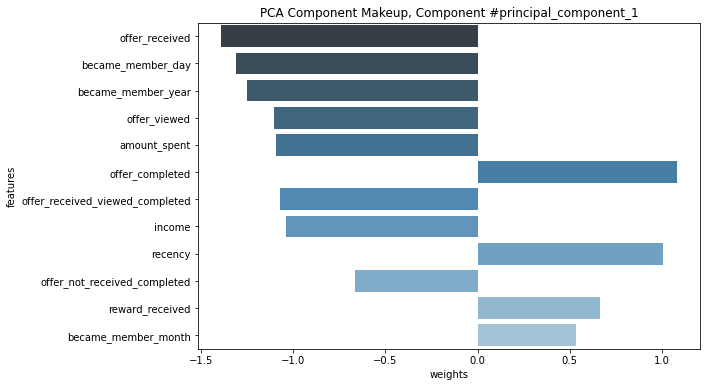

In [14]:
feature_list = profile.select_dtypes(exclude='object').columns.tolist()
component_makeup(profile_pca, feature_list, 'principal_component_1', 12)

- Taking the first principle component as an example, we observed that features such as "offer_received", "became_member_day", and "offer_viewed" have the highest weight. In other words, this component intends to transform each customer's record based on emphasising the features described above. 

In [15]:
# concatenating the PCA resultss with the categorical variable

profile_ktype = profile.select_dtypes(include='object').join(profile_pca.iloc[:,:7].set_index(profile.index))\
.drop(['r_quartile',
       'f_quartile', 'm_quartile'], axis=1)

# filling in missing values with "-1" using cat.codes

cat_cols = profile_ktype.select_dtypes(include=['object']).columns.tolist()
for each in cat_cols:
    profile_ktype[each] = profile_ktype[each].astype('category')
    profile_ktype[each] = profile_ktype[each].cat.codes
    profile_ktype[each] = profile_ktype[each].astype('category')
    
# list of column index that represent categorical features

cat_cols = [i for i,v in enumerate(profile_ktype.dtypes) if str(v) == 'category']

<function matplotlib.pyplot.show(*args, **kw)>

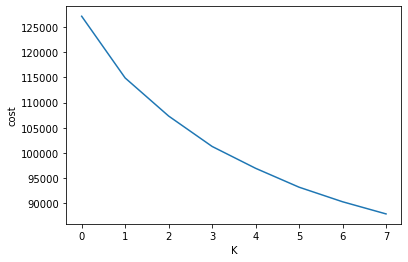

In [16]:
# k-prototype clustering
# elbow method to choose an optimal k value

cost = []
for num_clusters in list(range(2,10)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=123, n_jobs=-1, n_init=10) 
    kproto.fit_predict(profile_ktype, categorical=cat_cols)
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

- As expected, the elbow method did not suggest that there is a natural distinct groupings. To save computation times, I will choose number of clusters to be at 4.

In [17]:
# k-prototype clusterin

kproto = KPrototypes(n_clusters=4, init='Huang', random_state=123, n_jobs=-1) 
kproto.fit_predict(profile_ktype, categorical=cat_cols)

# append the clustering results to the original profile dataset

profile['clusters'] = kproto.labels_

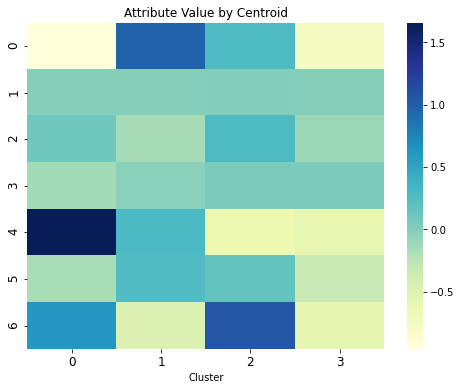

In [18]:
# visualize numerical attributes contribution for each cluster via cluster centroids

plt.figure(figsize = (8,6))
ax = sns.heatmap(pd.DataFrame(kproto.cluster_centroids_[0]).T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_title("Attribute Value by Centroid")
plt.show()

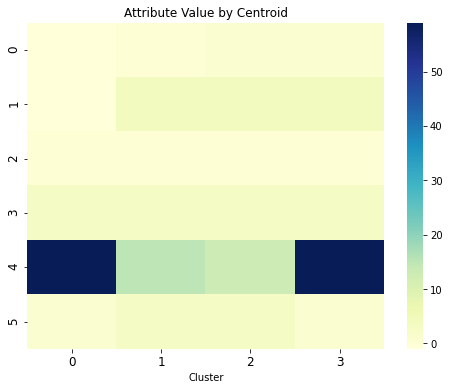

In [19]:
# visualize categorical attributes contribution for each cluster via cluster centroids

plt.figure(figsize = (8,6))
ax = sns.heatmap(pd.DataFrame(kproto.cluster_centroids_[1]).T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
ax.set_title("Attribute Value by Centroid")
plt.show()

- For cluster 1, the cluster centroid is placed mostly within principle component 5, 7 and categorical feature "rfm_score".
- For cluster 2, the cluster centroid is placed mostly within principle component 1.
- for cluster 3, the cluster centroid is placed mostly within principle component 7.
- For cluster 4, the cluster centroid is placed mostly within categorical feature "rfm_score".

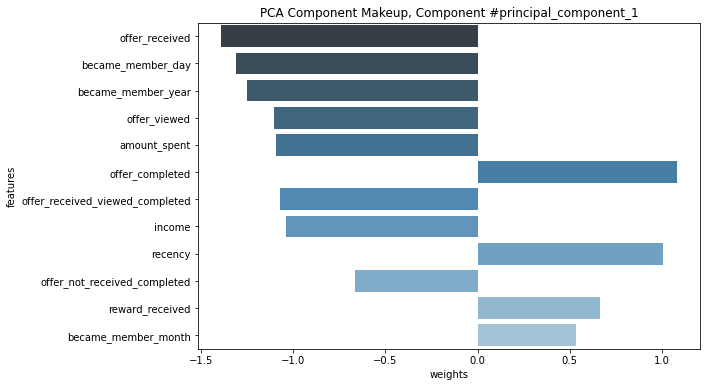

In [20]:
component_makeup(profile_ktype, feature_list, 'principal_component_1', 12)

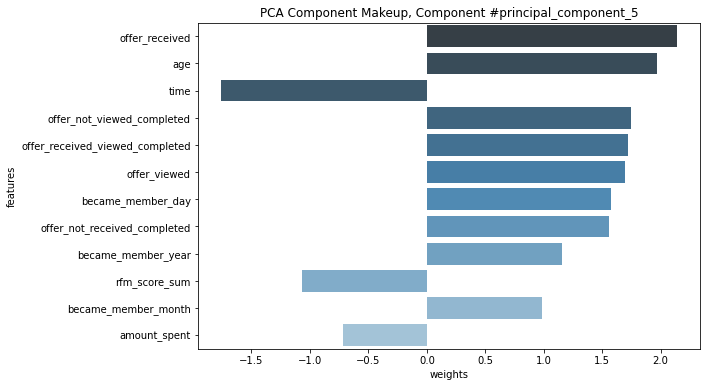

In [21]:
component_makeup(profile_ktype, feature_list, 'principal_component_5', 12)

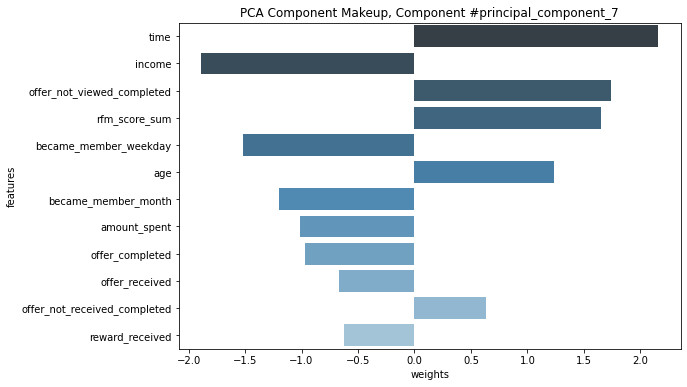

In [22]:
component_makeup(profile_ktype, feature_list, 'principal_component_7', 12)

### 2. K-prototype clustering conclusion

Summary:
- In this section, we first performed a Principle Component Analysis and concluded that only the first 7 components will be used in the later clustering process since these components contributes towards 88% of the total variance explained. 
- Secondly, K-prototype algorithm is choosen to be performed in the clustering section due to its ability to interpretate categorical features. Although there is no distinct groupings found via the elbow method, I choose to define 4 clusters for the purpose of saving computaion time.

Conclusion:
- Features that are heavily relied on by all the clusters are: principle component 1, 5, 7 and along with a categorical feature "rfm_score" (the rfm segmentation results obtained from previous section).
- Principle component 1 major features:
    - offer_received, become_member_day and year, offer_viewed
- Principle component 5 major features:
    - offer_received, age, time, and offer_not_viewed_completed
- Principle component 7 major features:
    - time, income, offer_not_viewed_completed, rfm_score_sum

## Component conclusion

Questions to answer:
1. When people make certain decisions about the offers, are there any common characteristics that these people share? 
2. How does the customer groups labeled as ideal and valuable react to each offer types?

Findings:
1. Using the RFM segmentation method, it is observed that customers with the segment score of 3 and 4 (these are the lowest possible scores) have the highest average monetary value, these customers should be labeled as most ideal to the business. Customers from this group commonly spend above \\$200 dollars on average during the entire testing period.

    - The ideal customer group counted as 12.7\% of the population, ranked as the third largest group among all customers.
    
2. Customers with RFM score from 5 to 7 should be interpreted together because their average monetary value are all above \\$100 dollars. Thus, these customers are labeled as "valuable" to the business.

    - The "valuable" customer group counted as 32.4\% of the population, and ranked the second largest group of the all segmentations.

3. Among these two preferred groups, customers are expected to have higher average purchase amount, high number of completed offers, and their last interaction with the offers they receive is very close to the time that this anlaysis is performed.

4. Customers with RFM score from 8 to 11 should be interpreted together because their average monetary value are all less than \\$100 dollars but still maintaining 2-digit average spent amount. We assume that the business like to encourage these customers, therefore, this segment is labeled as "need to reach out".

I will answer the question "how does the customer groups labeled as ideal and valuable react to each type of offer" in the next component analysis since this would require to join the processed profile dataset (with RFM segment results appended) with the processed transcript dataset.

In [26]:
# prepare the datasets to be used in the next component

import os
data_dir = '../Data/Processed'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

profile.to_csv(os.path.join(data_dir, 'profile_processed2.csv'), header=True, index=True)